# Experiment: building a variational Bayesian mixture density networks

This is based on tutorial_mdn.ipynb but implements a Bayesian version of the mixture density network.

## Example: inverted noisy oscillatory data

Import the packages we will use.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
# Tell tensorflow to use double precision:
tf.keras.backend.set_floatx('float64')

Generate example data.

In [2]:
def generate_data(N, noise_scale=0.2, seed=1):
    rng = np.random.default_rng(seed=seed)
    Y = rng.uniform(low=-1., high=1., size=N).T
    xi = rng.normal(size=N)
    noise = xi * noise_scale
    X = np.sin(10 * Y) + Y
    X += noise  # Additive Gaussian noise.
    X /= 3
    return X, Y

X, Y = generate_data(3200, seed=1)

Plot the data.

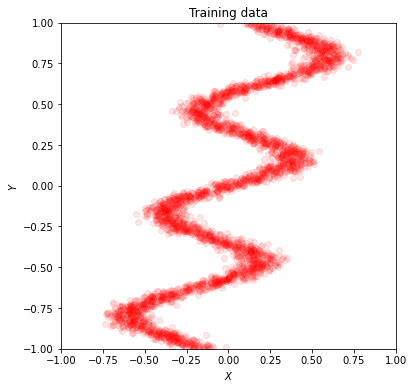

In [3]:
plt.figure(figsize=(6, 6))
plt.plot(X, Y, 'ro', alpha=0.1)
plt.xlabel(r'$X$'); plt.ylabel(r'$Y$')
plt.title('Training data')
plt.xlim(-1., 1.)
plt.ylim(-1., 1.)
plt.show()

Now we will build a mixture density network, replacing some standard hidden layers with variational Bayesian layers, where each weight is Gaussian with its own mean and standard deviation learned during training.

In [178]:
from dn import Gm  # Import custom Gaussian mixture object.
tfd = tfp.distributions

# Data parameters
BATCH_SIZE = 32                         # Size of minibatches for optimisation algorithm
I_SIZE = 1                              # Dimension of X
O_SIZE = 1                              # Dimension of Y

# Network hyperparameters
N_C = 24                                # Number of mixture components
N_HL = 6                                # Number of hidden layers
N_HU = [256] * N_HL                      # Numbers of units in hidden layers
HL_ACTIVATION = 'relu'                  # Activation on hidden layer units

# Initialise Gaussian mixture "layer"
gm = Gm(o_size=O_SIZE, n_c=N_C, scale_type='tril')


def build_nn():
    """ Initialise neural network. """
    # Create input layer.
    l_i = tf.keras.layers.Input(shape=(I_SIZE), name='input_layer',
                                batch_size=BATCH_SIZE)

    # Make hidden layers.
    h_layers = []
    for hl_i in range(len(N_HU)):
        if hl_i == 0:
            h_layers.append(tf.keras.layers.Dense(
                N_HU[hl_i], activation=HL_ACTIVATION,
                name='hidden_layer_{}'.format(hl_i))(l_i))
        elif hl_i < N_HL - 2:
            h_layers.append(tf.keras.layers.Dense(
                N_HU[hl_i], activation=HL_ACTIVATION,
                name='hidden_layer_{}'.format(hl_i))(h_layers[-1]))
        else:
            h_layers.append(tfp.layers.DenseReparameterization(
                N_HU[hl_i],
                activation=HL_ACTIVATION, name='hidden_layer_{}'.format(hl_i))(h_layers[-1]))
    # Make output layer.
    l_o = tf.keras.layers.Dense(gm.params_size, use_bias=False,
                                name='params_layer')(h_layers[-1])

    # Construct model
    neural_net = tf.keras.models.Model(l_i, l_o)
    return neural_net

NN = build_nn()

Next we will train the model.

In [195]:
# Training parameters
LOSS = gm.nll_reg
METRICS = None
LEARNING_RATE = 5e-4
OPTIMISER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
EPOCHS = 200

# Compile and train model
NN.compile(loss=LOSS, optimizer=OPTIMISER, metrics=METRICS)
History = NN.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE,
                 validation_split=0.5, verbose=0)

See how training and test loss progresses during training.

In [196]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), History.history['loss'], 'k',
         label='Training loss')
plt.plot(range(1, EPOCHS + 1), History.history['val_loss'], 'r',
         label='Test loss')
plt.xlabel('Epoch')
# plt.yscale('log')
plt.legend()
plt.show()

Plotting the learned conditional density. Really a sample of the conditional density at each $(X,Y)$.

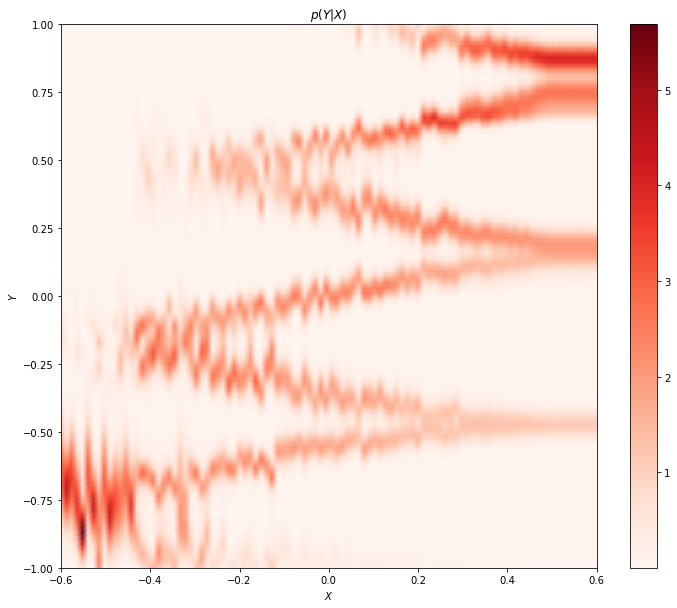

In [190]:
gm.neural_net = NN
n = 100
x = np.linspace(-0.6, 0.6, n)
y = np.linspace(-1., 1., n)
xx, yy = np.meshgrid(x, y)
pyx = np.zeros((n, n))
for i in range(n):
    pyx[i, :] = gm.density(x[i, None, None], y[:, None])

plt.figure(figsize=(12, 10))
plt.pcolormesh(xx, yy, pyx.T, cmap='Reds', shading='gouraud')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$p(Y|X)$')
plt.colorbar()
plt.show()

Looking at $p(Y|X)$ for a particular value of $X$.

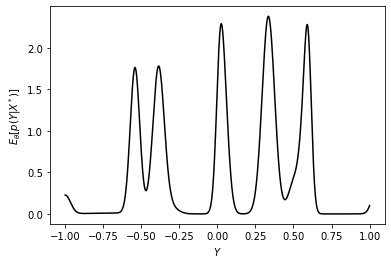

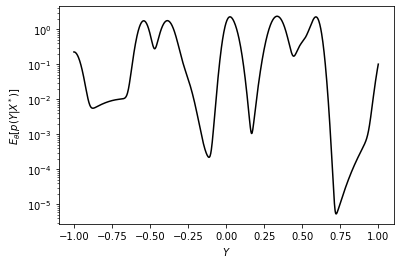

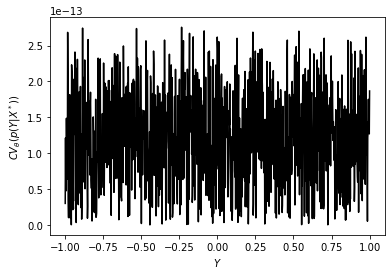

In [200]:
x_star = np.array((0.,)).reshape((1, I_SIZE))
ny = 1000
ys = np.linspace(-1., 1., ny).reshape((ny, O_SIZE))
# pygx_star = gm.density(x_star, ys)

reps = 10000  # Number of samples of density for each value of Y.
ys_rep = np.tile(ys, (reps, 1))
pygx_star_rep = gm.density(x_star, ys_rep).numpy().reshape((reps, ny)).T
pygx_star_mean = np.mean(pygx_star_rep, axis=-1)
pygx_star_cv = np.std(pygx_star_rep, axis=-1) / pygx_star_mean

plt.figure(figsize=(6, 4))
plt.plot(ys, pygx_star_mean, 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$E_\theta[p(Y|X^*)]$')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, pygx_star_mean, 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$E_\theta[p(Y|X^*)]$')
plt.yscale('log')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, pygx_star_cv, 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$CV_\theta(p(Y|X^*))$')
plt.show()